#Disney Optimization Code

#Install Pyomo and Solvers

In [ ]:
!pip install -q pyomo

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.7/12.7 MB 22.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 2.5 MB/s eta 0:00:00


In [ ]:
#Import Pyomo
import pyomo.environ as pyo

In [ ]:
#Install Solvers
%%capture
import sys
import os

if 'google.colab' in sys.modules:
    !pip install idaes-pse --pre
    !idaes get-extensions --to ./bin
    os.environ['PATH'] += ':bin'

#Iteration 1

##Import the Data

In [ ]:
#Upload disney_rides.csv file
from google.colab import files
files.upload()

Saving disney_rides.csv to disney_rides.csv


{'disney_rides.csv': b'hour,avg_wait_time,date,ride\r\n0,86.78571428571429,1,seven_dwarfs\r\n1,55.55555555555556,1,seven_dwarfs\r\n7,32.142857142857146,1,seven_dwarfs\r\n8,63.13953488372093,1,seven_dwarfs\r\n9,72.53968253968254,1,seven_dwarfs\r\n10,85.22388059701493,1,seven_dwarfs\r\n11,92.72727272727273,1,seven_dwarfs\r\n12,101.56716417910448,1,seven_dwarfs\r\n13,108.43283582089552,1,seven_dwarfs\r\n14,116.41666666666667,1,seven_dwarfs\r\n15,111.42857142857143,1,seven_dwarfs\r\n16,109.2741935483871,1,seven_dwarfs\r\n17,101.44067796610169,1,seven_dwarfs\r\n18,92.41666666666667,1,seven_dwarfs\r\n19,80.27272727272727,1,seven_dwarfs\r\n20,68.88888888888889,1,seven_dwarfs\r\n21,56.458333333333336,1,seven_dwarfs\r\n22,64.13461538461539,1,seven_dwarfs\r\n23,49.629629629629626,1,seven_dwarfs\r\n0,57.05882352941177,2,seven_dwarfs\r\n1,40,2,seven_dwarfs\r\n6,30,2,seven_dwarfs\r\n7,31.153846153846153,2,seven_dwarfs\r\n8,53,2,seven_dwarfs\r\n9,79.55357142857143,2,seven_dwarfs\r\n10,111,2,seven_dw

In [ ]:
#Read disney data from CSV
import pandas as pd
# (path to data file, excel sheet in data file, row index of headers, col index of row labels)
disney_df = pd.read_csv('disney_rides.csv', header = 0)

In [ ]:
disney_df.head(10)

,hour,avg_wait_time,date,ride
0,0,86.785714,1,seven_dwarfs
1,1,55.555556,1,seven_dwarfs
2,7,32.142857,1,seven_dwarfs
3,8,63.139535,1,seven_dwarfs
4,9,72.539683,1,seven_dwarfs
5,10,85.223881,1,seven_dwarfs
6,11,92.727273,1,seven_dwarfs
7,12,101.567164,1,seven_dwarfs
8,13,108.432836,1,seven_dwarfs
9,14,116.416667,1,seven_dwarfs


In [ ]:
'''
# Idea for distance variable (not used)
Epcot = [ r1, r2 , r3]
Animal_Kingdom = [r4, r5]

Location = [[ r1, r2], [r1, r3], ...]
Distance = [1, 1, 99999999, 999999]

dist = { (r1, r2) : 1, (r1, r3) : 1}
'''

##Build the (Optimal) Model

In [ ]:
#Define a concrete model
model = pyo.ConcreteModel()


In [ ]:
i = 117  # select the starting date (1-indexed!, so i=1 is January 1st. Can't go past i=(366-7) or this will break)
R = list(pd.unique(disney_df.ride))  # list of rides
D = list(range(i, i+7))  # date range (7 days)
H = list(range(0, 24))  # list of hours (military time)

#Define index sets
model.R = pyo.Set(initialize=R)
model.D = pyo.Set(initialize=D)
model.H = pyo.Set(initialize=H)

In [ ]:
# Extract data
wait = disney_df.loc[:, ["avg_wait_time"]]
wait_dict = {(r, d, h) : wait.loc[(disney_df["date"]==d) & (disney_df["hour"]==h) & (disney_df["ride"]==r)] \
             for r in R for d in D for h in H}

In [ ]:
# Use naive method to convert dataframe values in dictionary to float
for keys in wait_dict:
    if not wait_dict[keys].empty:
        wait_dict[keys] = wait_dict[keys].iloc[0,0]
        #print(wait_dict[keys])
    else:
        wait_dict[keys] = 999999 # Dummy value for NA values (hours where there are no rides)
        #print(wait_dict[keys])

In [ ]:
#Define parameter
model.t = pyo.Param(model.R, model.D, model.H, initialize=wait_dict)

In [ ]:
# Define decision variable
model.x = pyo.Var(model.R, model.D, model.H, domain = pyo.Binary)

In [ ]:
#Define the objective
def obj_rule(model):
  return sum(model.t[r, d, h] * model.x[r, d, h] for r in model.R for d in model.D for h in model.H)

model.obj = pyo.Objective(rule = obj_rule, sense = pyo.minimize)

In [ ]:
#Define the constraints
def constraint1_rule(model, d, h):
  return 1 >= sum(model.x[r,d,h] for r in model.R)

model.constraint1 = pyo.Constraint(model.D, model.H, rule = constraint1_rule) # Can't ride more than 1 for one time slot

def constraint2_rule(model, r):
  return 1 <= sum(model.x[r,d,h] for d in model.D for h in model.H)

model.constraint2 = pyo.Constraint(model.R, rule = constraint2_rule) # Have to ride each ride at least once during the week

In [ ]:
model.constraint2.pprint()

constraint2 : Size=14, Index=R, Active=True
    Key               : Lower : Body                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        

##Solve the Model

In [ ]:
#Declare the solver as CBC
opt = pyo.SolverFactory('cbc')

#Solve model
opt.solve(model)
print("objective =", pyo.value(model.obj))


objective = 58.92857142857143


In [ ]:
x_values = model.x.extract_values()
for value in x_values.keys():
  if x_values[value] == 1:
    print(value)

('seven_dwarfs', 122, 7)
('alien_saucers', 119, 7)
('dinosaur', 122, 21)
('everest', 122, 22)
('flight_of_passage', 117, 7)
('kilimanjaro', 119, 22)
('navi_river', 118, 6)
('pirates_carribean', 117, 0)
('rock_n_roller', 120, 7)
('slinky_dog', 123, 0)
('soarin', 123, 23)
('spaceship', 118, 7)
('splash_mount', 118, 0)
('toy_story', 117, 22)


##Find the Optimal Week Period

In [ ]:
# Create empty list
obj_values = list()

#Solve for each value of alpha
for i in list(range(1, 360)):
  model.clear()
  D = list(range(i, i+7))  # date range (7 days)
  #Define index sets
  model.R = pyo.Set(initialize=R)
  model.D = pyo.Set(initialize=D)
  model.H = pyo.Set(initialize=H)
  # Extract data
  wait_dict = {(r, d, h) : wait.loc[(disney_df["date"]==d) & (disney_df["hour"]==h) & (disney_df["ride"]==r)] \
               for r in R for d in D for h in H}
  # Use naive method to convert dataframe values in dictionary to float
  for keys in wait_dict:
      if not wait_dict[keys].empty:
          wait_dict[keys] = wait_dict[keys].iloc[0,0]
      else:
          wait_dict[keys] = 999999 # Dummy value for NA values (hours where there are no rides)
  #Define parameter
  model.t = pyo.Param(model.R, model.D, model.H, initialize=wait_dict)
  # Define decision variable
  model.x = pyo.Var(model.R, model.D, model.H, domain = pyo.Binary)
  #Define the objective
  model.obj = pyo.Objective(rule = obj_rule, sense = pyo.minimize)
  model.constraint1 = pyo.Constraint(model.D, model.H, rule = constraint1_rule) # Can't ride more than 1 for one time slot
  model.constraint2 = pyo.Constraint(model.R, rule = constraint2_rule) # Have to ride each ride at least once during the week
  #Declare the solver as CBC
  opt = pyo.SolverFactory('cbc')
  #Solve model
  opt.solve(model)
  x_values = model.x.extract_values()
  #for value in x_values.keys():
   # if x_values[value] == 1:
    #  print(value)
  print("day =", i, "objective =", pyo.value(model.obj))
  obj_values.append(pyo.value(model.obj))

day = 1 objective = 88.93333333333334
day = 2 objective = 85.6
day = 3 objective = 80.0
day = 4 objective = 80.0
day = 5 objective = 80.0
day = 6 objective = 75.0
day = 7 objective = 75.0
day = 8 objective = 77.0
day = 9 objective = 72.5
day = 10 objective = 76.25
day = 11 objective = 76.25
day = 12 objective = 76.25
day = 13 objective = 71.25
day = 14 objective = 71.25
day = 15 objective = 78.75
day = 16 objective = 73.75
day = 17 objective = 71.25
day = 18 objective = 71.25
day = 19 objective = 71.25
day = 20 objective = 66.25
day = 21 objective = 67.5
day = 22 objective = 67.5
day = 23 objective = 67.5
day = 24 objective = 68.08333333333334
day = 25 objective = 68.75
day = 26 objective = 68.75
day = 27 objective = 68.75
day = 28 objective = 68.75
day = 29 objective = 74.16666666666667
day = 30 objective = 83.61111111111111
day = 31 objective = 87.9554162312783
day = 32 objective = 83.51097178683386
day = 33 objective = 83.51097178683386
day = 34 objective = 83.51097178683386
day = 3

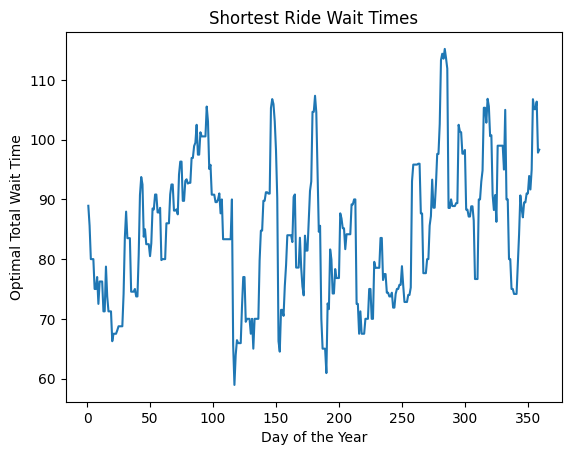

In [ ]:
# Import matplotlib
import matplotlib.pyplot as plt

# Plot every objective value for each day
plt.plot(list(range(1, 360)), obj_values)
plt.title("Shortest Ride Wait Times")
plt.xlabel("Day of the Year")
plt.ylabel("Optimal Total Wait Time")
plt.show()

In [ ]:
# Print shortest total wait time and the corresponding date
print(min(obj_values))
obj_values.index(min(obj_values)) + 1

58.92857142857143


117

#Iteration 2

##Import the Data

In [ ]:
# Upload disney_rides_8_to_9.csv
import pandas as pd
from google.colab import files
files.upload()

# (path to data file, excel sheet in data file, row index of headers, col index of row labels)
disney_df_subset = pd.read_csv('disney_rides_8_to_9.csv', header = 0)

Saving disney_rides_8_to_9.csv to disney_rides_8_to_9.csv


##Find the Optimal Week Period

In [ ]:
# Create empty list
obj_values = list()
model = pyo.ConcreteModel()

#Solve for each value of alpha
for i in list(range(1, 360)):
  model.clear()
  R = list(pd.unique(disney_df_subset.ride))  # list of rides
  D = list(range(i, i+7))  # date range (7 days)
  H = list(range(0, 24))  # list of hours (military time)
  #Define index sets
  model.R = pyo.Set(initialize=R)
  model.D = pyo.Set(initialize=D)
  model.H = pyo.Set(initialize=H)
  # Extract data
  wait = disney_df_subset.loc[:, ["avg_wait_time"]]
  wait_dict = {(r, d, h) : wait.loc[(disney_df_subset["date"]==d) & (disney_df_subset["hour"]==h) & (disney_df_subset["ride"]==r)] \
               for r in R for d in D for h in H}
  # Use naive method to convert dataframe values in dictionary to float
  for keys in wait_dict:
      if not wait_dict[keys].empty:
          wait_dict[keys] = wait_dict[keys].iloc[0,0]
      else:
          wait_dict[keys] = 999999 # Dummy value for NA values (hours where there are no rides)
  #Define parameter
  model.t = pyo.Param(model.R, model.D, model.H, initialize=wait_dict)
  # Define decision variable
  model.x = pyo.Var(model.R, model.D, model.H, domain = pyo.Binary)
  #Define the objective
  model.obj = pyo.Objective(rule = obj_rule, sense = pyo.minimize)
  #Define the constraints
  model.constraint1 = pyo.Constraint(model.D, model.H, rule = constraint1_rule) # Can't ride more than 1 for one time slot
  model.constraint2 = pyo.Constraint(model.R, rule = constraint2_rule) # Have to ride each ride at least once during the week
  #Declare the solver as CBC
  opt = pyo.SolverFactory('cbc')
  #Solve model
  opt.solve(model)
  x_values = model.x.extract_values()
  #for value in x_values.keys():
   # if x_values[value] == 1:
    #  print(value)
  print("day =", i, "objective =", pyo.value(model.obj))
  obj_values.append(pyo.value(model.obj))

day = 1 objective = 214.91558575
day = 2 objective = 192.50872301
day = 3 objective = 160.796350192
day = 4 objective = 151.902672827
day = 5 objective = 147.123261067
day = 6 objective = 133.002619169
day = 7 objective = 130.6835956
day = 8 objective = 130.8835956
day = 9 objective = 131.35107527
day = 10 objective = 129.65567297
day = 11 objective = 130.179202382
day = 12 objective = 129.76476387900001
day = 13 objective = 143.797021939
day = 14 objective = 147.143883411
day = 15 objective = 137.956300454
day = 16 objective = 140.389073564
day = 17 objective = 125.147058824
day = 18 objective = 125.647058824
day = 19 objective = 127.117647059
day = 20 objective = 125.623249304
day = 21 objective = 105.623249304
day = 22 objective = 109.923249304
day = 23 objective = 120.956066639
day = 24 objective = 118.559523813
day = 25 objective = 107.97619048
day = 26 objective = 104.72222222
day = 27 objective = 98.29365079
day = 28 objective = 118.29365079
day = 29 objective = 123.71031746
day

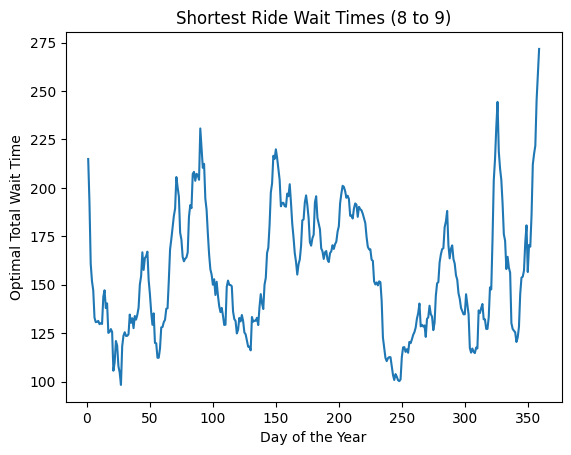

In [ ]:
# Plot every objective value for each day
import matplotlib.pyplot as plt
plt.plot(list(range(1, 360)), obj_values)
plt.title("Shortest Ride Wait Times (8 to 9)")
plt.xlabel("Day of the Year")
plt.ylabel("Optimal Total Wait Time")
plt.show()

In [ ]:
# Print shortest total wait time and the corresponding date
print(min(obj_values))
obj_values.index(min(obj_values)) + 1

98.29365079


27

##Build and Solve the Optimal Model

In [ ]:
model.clear()
i = 27
R = list(pd.unique(disney_df_subset.ride))  # list of rides
D = list(range(i, i+7))  # date range (7 days)
H = list(range(0, 24))  # list of hours (military time)

#Define index sets
model.R = pyo.Set(initialize=R)
model.D = pyo.Set(initialize=D)
model.H = pyo.Set(initialize=H)

# Extract data
wait = disney_df_subset.loc[:, ["avg_wait_time"]]
wait_dict = {(r, d, h) : wait.loc[(disney_df_subset["date"]==d) & (disney_df_subset["hour"]==h) & (disney_df_subset["ride"]==r)] \
             for r in R for d in D for h in H}

# Use naive method to convert dataframe values in dictionary to float
for keys in wait_dict:
    if not wait_dict[keys].empty:
        wait_dict[keys] = wait_dict[keys].iloc[0,0]
    else:
        wait_dict[keys] = 999999 # Dummy value for NA values (hours where there are no rides)

#Define parameter
model.t = pyo.Param(model.R, model.D, model.H, initialize=wait_dict)

# Define decision variable
model.x = pyo.Var(model.R, model.D, model.H, domain = pyo.Binary)

#Define the objective
model.obj = pyo.Objective(rule = obj_rule, sense = pyo.minimize)

#Define the constraints
model.constraint1 = pyo.Constraint(model.D, model.H, rule = constraint1_rule) # Can't ride more than 1 for one time slot
model.constraint2 = pyo.Constraint(model.R, rule = constraint2_rule) # Have to ride each ride at least once during the week

#Declare the solver as CBC
opt = pyo.SolverFactory('cbc')

#Solve model
opt.solve(model)

print("objective =", pyo.value(model.obj))
x_values = model.x.extract_values()
for value in x_values.keys():
  if x_values[value] == 1:
    print(value)

objective = 98.29365079
('seven_dwarfs', 28, 8)
('alien_saucers', 31, 20)
('dinosaur', 30, 21)
('everest', 29, 20)
('flight_of_passage', 29, 8)
('kilimanjaro', 33, 8)
('navi_river', 31, 21)
('pirates_carribean', 27, 8)
('rock_n_roller', 33, 21)
('slinky_dog', 27, 20)
('soarin', 27, 21)
('spaceship', 28, 21)
('splash_mount', 28, 20)
('toy_story', 32, 20)
